## About this Notebook

In this kernel, I work on the IMDB movie review dataset and to predict sentiments from the movie review. I will visualize the dataset using seaborn and will perform text preprocessing. It is an imbalanced dataset, so i will try to solve that problem as well. 



## 1. Import Libraries

In [41]:
# python libraries to read & plot data
import pandas as pd
import numpy as np
import string
import pickle
import seaborn as sns
sns.set_style('darkgrid')

# sklearn libraries for prediction and evaluation
from sklearn import model_selection, preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.tree import DecisionTreeClassifier

# imblearn for balancing dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline,make_pipeline

# nltk for text processing
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

# Remove Special Charactors
import re

# 2. Data Exploration

In [2]:
# Read dataset from local machine
df = pd.read_csv(r'C:\Users\kvbt565\Desktop\IMDB Usecase\IMDB Dataset\IMDB Dataset.csv')
print("Data Set:"% df.columns, df.shape, len(df))

Data Set: (27502, 2) 27502


In [3]:
df.describe()

,review,sentiment
count,27502,27502
unique,27358,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
# Percentage of Positive/Negative
print("Positive: ", df.sentiment.value_counts()[0]/len(df)*100,"%")
print("Negative: ", df.sentiment.value_counts()[1]/len(df)*100,"%")

Positive:  90.90247981964949 %
Negative:  9.09752018035052 %


Clearly, we have an imbalanced dataset and need to consider balancing dataset before prediction

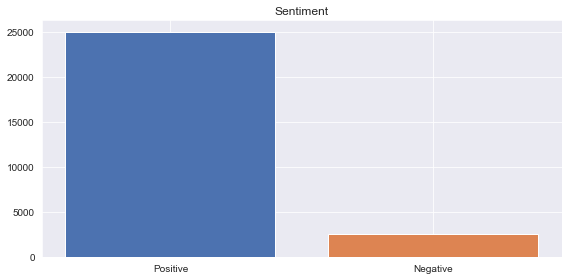

In [5]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df['sentiment'].value_counts(),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

## 3. Data Preprocessing

In [6]:
movie_review = df.copy()

In [7]:
# Stemmer to update the root word
porter=PorterStemmer()

# Stopwords except 'from'
all_stopwords = stopwords.words('english')
all_stopwords.remove('from')
#all_stopwords.extend(['the' , 'to' , 'it' , 'i' , 't'])

In [8]:
# Change text to lowercase
movie_review['review'] = movie_review['review'].str.lower()

# Removing xml related characters
movie_review['review'] = movie_review['review'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

# Removing Non-Digit and Non-letter parts
movie_review['review'] = movie_review['review'].replace(to_replace=r"[^A-Za-z0-9]+", value=r" ", regex=True)
#movie_review['review'] = movie_review['review'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))

# Removing standalone numbers
movie_review['review'] = movie_review['review'].apply(lambda x: ' '.join([word for word in x.split() if not word.isdigit()]))

# Removing stopwords 
movie_review['review'] = movie_review['review'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (all_stopwords)]))

# Updating the text to its root word
movie_review['review'] = movie_review['review'].apply(lambda x :' '.join([porter.stem(word) for word in x.split()]))

In [9]:
# Separate the Dataset into feature & target dataframes
X = movie_review['review']
Y = movie_review['sentiment']

## 4. Split Train Test Data

Splitting 80% of data as trian data & 20% of data as test data

In [45]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.20, random_state=7)

In [46]:
# Encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [47]:
print("Count of positive class in trainig data set :" ,(sum(y_train==1)))
print("Count of negative class in trainig data set :",format(sum(y_train==0)))

Count of positive class in trainig data set : 19978
Count of negative class in trainig data set : 2023


In [48]:
print("Count of positive class in testing data set :" ,(sum(y_test==1)))
print("Count of negative class in testing data set :",format(sum(y_test==0)))

Count of positive class in testing data set : 5022
Count of negative class in testing data set : 479


In [78]:
print(x_test[18887])

great concert featur best song band year career lee lifeson peart anim fun stage deliv great show said think audio record botch mix consol mike process fault boy howev even mention show setup last minut band crew obvious best put show public consumpt neil snare sound distant geddi bass good harmon content bottom end held concert wait better occas buy dvd hardcor rushian qualiti lack audio depart


In [90]:
np.any(y_train[:] == 1)

True

In [99]:
test.to_csv(r'test_imdb.csv')

In [98]:
test = pd.DataFrame(x_test)
test.reset_index(inplace=True)
test['sentiment'] = y_test.tolist()
test

,index,review,sentiment
0,18887,great concert featur best song band year caree...,1
1,15369,scale suicid sweetheart got from from everyon ...,1
2,13761,six month old babi home time time fight sleep ...,1
3,12189,came sneak preview film laugh everi sec end fu...,1
4,5522,whilst love haunt hous movi amityvil poltergei...,1
...,...,...,...
5496,17214,noth like moonstruck from new york italian fam...,1
5497,11408,great film mccartney beatl fan splendid time g...,1
5498,2993,must admit one favorit horror film time uniqu ...,1
5499,13631,clich avoid one film main achiev hear vagu out...,1


## 5. Vectorization

We need to convert the text into numerical values before passing it to the Model for training & prediction. Basic algorithms like one-hot encoder, Count Vectorizer can be used but i am using Tf-Idf vectorizer since it performs much better and provides a logical vectorization.

We can also use other embedding techinques like Word2vec, Glove Or BERT which will give us the context based importance of the words

5.1 Tf-idf Vectorization

Term Frequency             --> tf(t,d) = count of t in d / number of words in d <br>
Document Frequency         --> df(t)   = occurrence of t in documents  <br>
Inverse Document Frequency --> idf(t) = log(N/(df + 1)) <br>
TF - IDF                   --> tf-idf(t, d) = tf(t, d) * log(N/(df + 1)) 


In [49]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
xtrain_tfidf =  tfidf_vect.fit_transform(x_train)
xtest_tfidf =  tfidf_vect.transform(x_test)

In [50]:
print('Tfidf_train:',xtrain_tfidf.shape)
print('Tfidf_test:',xtest_tfidf.shape)

Tfidf_train: (22001, 48202)
Tfidf_test: (5501, 48202)


## 6. Balancing dataset & Model Selection

Here I am trying to explore the right algorithm for balancing the dataset and also the right model for prediction. Also, i used F1 score to evaluate the performance for each model as it gives better results for imbalanced dataset


In [51]:
# Return the F1 Score
def train_model(classifier, vector_train, tgt, vector_test):    
    classifier.fit(vector_train, tgt)    
    predictions = classifier.predict(vector_test)
    return metrics.f1_score(y_test,predictions)

In [53]:
# Random Over Sampling
ros = RandomOverSampler(random_state=777)
ros_xtrain_tfidf, ros_train_y = ros.fit_resample(xtrain_tfidf, y_train)

# Logistic Regression
Acc_Ros = train_model(LogisticRegression(random_state=0,multi_class='multinomial'),ros_xtrain_tfidf, ros_train_y, xtest_tfidf)
print ("LR Baseline, WordLevel TFIDF: ", Acc_Ros)

# Support Vector classification
Acc_Ros = train_model(svm.LinearSVC(), ros_xtrain_tfidf, ros_train_y, xtest_tfidf)
print ("SVM Baseline, WordLevel TFIDF: ", Acc_Ros)

# Decision Tree classifier
Acc_Ros = train_model(DecisionTreeClassifier(), ros_xtrain_tfidf, ros_train_y, xtest_tfidf)
print ("Decision Tree Baseline, WordLevel TFIDF: ", Acc_Ros)

LR Baseline, WordLevel TFIDF:  0.975349632759835
SVM Baseline, WordLevel TFIDF:  0.9765492465821775
Decision Tree Baseline, WordLevel TFIDF:  0.9493607168025773


In [392]:
# Random Under Sampling
rus = RandomUnderSampler(random_state=777)
rus_xtrain_tfidf, rus_train_y = rus.fit_resample(xtrain_tfidf, y_train)

# Logistic Regression
Acc_Rus = train_model(LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),rus_xtrain_tfidf, rus_train_y, xtest_tfidf)
print("LR ORIGINAL, WordLevel TFIDF: ", Acc_Rus)
     
# Support Vector classification
Acc_Rus = train_model(svm.LinearSVC(),rus_xtrain_tfidf, rus_train_y, xtest_tfidf)
print ("SVM ROS, WordLevel TFIDF: ", Acc_Rus)

# Decision Tree classifier
Acc_Rus = train_model(DecisionTreeClassifier(), rus_xtrain_tfidf, rus_train_y, xtest_tfidf)
print ("Decision Tree Baseline, WordLevel TFIDF: ", Acc_Rus)

LR ORIGINAL, WordLevel TFIDF:  0.9596136060014387
SVM ROS, WordLevel TFIDF:  0.9566831683168316
Decision Tree Baseline, WordLevel TFIDF:  0.8739403280854343


In [404]:
# SMOTE(Synthetic Minority Oversampling Technique)
smote = SMOTE(sampling_strategy = 1 ,k_neighbors = 3, random_state=1)   
smot_train_tfidf, smot_train_y = smote.fit_resample(xtrain_tfidf, y_train)

# Logistic Regression
Smot_Rus = train_model(LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),smot_train_tfidf, smot_train_y, xtest_tfidf)
print("LR ORIGINAL, WordLevel TFIDF: ", Smot_Rus)
     
# Support Vector classification    
Smot_Rus = train_model(svm.LinearSVC(),smot_train_tfidf, smot_train_y, xtest_tfidf)
print ("SVM ROS, WordLevel TFIDF: ", Smot_Rus)

Smot_Rus = train_model(DecisionTreeClassifier(), smot_train_tfidf, smot_train_y, xtest_tfidf)
print ("Decision Tree Baseline, WordLevel TFIDF: ", Smot_Rus)

LR ORIGINAL, WordLevel TFIDF:  0.9812524930195452
SVM ROS, WordLevel TFIDF:  0.9797216699801192
Decision Tree Baseline, WordLevel TFIDF:  0.9338257925515543


From the above results sampling with SMOTE and prediction with Logistic Regression gives a better result. Hence, confirming the Accuracy as well for them

In [55]:
# Return the Accuracy Score
def train_model(classifier, vector_train, tgt, vector_test):    
    classifier.fit(vector_train, tgt)    
    predictions = classifier.predict(vector_test)
    return metrics.accuracy_score(y_test,predictions)

In [396]:
# SMOTE(Synthetic Minority Oversampling Technique) -- Accuraccy
smote = SMOTE(sampling_strategy = 1 ,k_neighbors = 3, random_state=1)   
smot_train_tfidf, smot_train_y = smote.fit_resample(xtrain_tfidf, y_train.ravel())

# Logistic Regression
Smot_Rus = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),smot_train_tfidf, smot_train_y, xtest_tfidf)
print("LR ORIGINAL, WordLevel TFIDF: ", Smot_Rus)
     
# Support Vector classification    
Smot_Rus = train_model(svm.LinearSVC(),smot_train_tfidf, smot_train_y, xtest_tfidf)
print ("SVM ROS, WordLevel TFIDF: ", Smot_Rus)

# Decision Tree classifier
Smot_Rus = train_model(DecisionTreeClassifier(), smot_train_tfidf, smot_train_y, xtest_tfidf)
print ("Decision Tree Baseline, WordLevel TFIDF: ", Smot_Rus)

LR ORIGINAL, WordLevel TFIDF:  0.9658243955644429
SVM ROS, WordLevel TFIDF:  0.9629158334848209
Decision Tree Baseline, WordLevel TFIDF:  0.8807489547355026


It is clear that Logistic Regression has an edge over SVM with SMOTE sampling. Now, its time to tune the Hyperparameters

## 7. Tuning the Model

In [400]:
# Set the parameters
params = {'solver':['lbfgs'],'C': [0.001,0.01,0.1,1,10],'random_state':[0],'multi_class':['multinomial']}

# Run Grid Search against different input Parameters
svc = LogisticRegression(max_iter=1000)
svc_grid = model_selection.GridSearchCV(svc,params, cv = 5)
svc_grid.fit(smot_train_tfidf, smot_train_y)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'multi_class': ['multinomial'], 'random_state': [0],
                         'solver': ['lbfgs']})

In [401]:
# Grid Search gives the best parameters for the model 
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

{'C': 10, 'multi_class': 'multinomial', 'random_state': 0, 'solver': 'lbfgs'}
LogisticRegression(C=10, max_iter=1000, multi_class='multinomial',
                   random_state=0)


## 8. Final Model & Pickling

Logistic Regression gives us better results, so trying to create a pipeline with imblearn and store the model as a pipeline to be predicted seperately

In [21]:
# Identified algorithms with their parameters
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
smote = SMOTE(sampling_strategy = 1 ,k_neighbors = 3, random_state=1)   
lr = LogisticRegression(random_state=0,C=10,max_iter=1000, solver='lbfgs',multi_class='multinomial')

In [29]:
# Create an imblearn pipeline
pipe = make_pipeline(tfidf, smote, lr)

In [32]:
# Fit the data against the pipeline
model = pipe.fit(x_train, y_train)
model

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=100000, token_pattern='\\w{1,}')),
                ('smote',
                 SMOTE(k_neighbors=3, random_state=1, sampling_strategy=1)),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=1000,
                                    multi_class='multinomial',
                                    random_state=0))])

In [33]:
# Create the pickle file
pickle.dump(model, open('classifier.pkl', 'wb'))

## 9. Model Evaluation

Evaluating the pipeline with test dataset

In [56]:
# Predicting the pipeline for test features
lr_predict=model.predict(x_test)
print(lr_predict)

[1 1 1 ... 1 1 1]


In [57]:
# Metrics from the pipeline
lf_accuracy=accuracy_score(y_test,lr_predict)
print("LR Accuracy Score :",lf_accuracy)

lf_precision=precision_score(y_test,lr_predict)
print("LR Precision Score :",lf_precision)

lf_recall=recall_score(y_test,lr_predict)
print("LR Recall Score :",lf_recall)

lf_f1=f1_score(y_test,lr_predict)
print("LR F1 Score :",lf_f1)

LR Accuracy Score : 0.9592801308852936
LR Precision Score : 0.9794164668265388
LR Recall Score : 0.9759060135404222
LR F1 Score : 0.9776580889686813


In [201]:
pip freeze

alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project==0.8.3
asn1crypto==1.0.1
astroid==2.3.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.2.0
Babel==2.7.0
backcall==0.1.0
backports.functools-lru-cache==1.5
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.8.0
bitarray==1.0.1
bkcharts==0.2
bleach==3.1.0
bokeh==1.3.4
boto==2.49.0
Bottleneck==1.2.1
certifi==2019.9.11
cffi==1.12.3
chardet==3.0.4
Click==7.0
cloudpickle==1.2.2
clyent==1.2.2
colorama==0.4.1
comtypes==1.1.7
conda==4.7.12
conda-build==3.18.9
conda-package-handling==1.6.0
conda-verify==3.4.2
contextlib2==0.6.0
cryptography==2.7
cycler==0.10.0
Cython==0.29.13
cytoolz==0.10.0
dask==2.5.2
decorator==4.4.0
defusedxml==0.6.0
distributed==2.5.2
docopt==0.6.2
docutils==0.15.2
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.1.0
filelock==3.0.12
Flask==1.1.1
fsspec==0.5.2
future==0.17.1
gevent==1.4.0
glob2==0.7
greenlet==0.4.

In [203]:
print(pandas.version)

NameError: name 'pandas' is not defined